# SAM3 Feature Extraction

Extract intermediate features, embeddings, and understand what happens inside SAM3.

In [1]:
# Cell 1: Load Model
import torch
from PIL import Image
from pathlib import Path
from transformers import Sam3Model, Sam3Processor
import matplotlib.pyplot as plt
import numpy as np

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("Loading SAM3 model...")
model = Sam3Model.from_pretrained("facebook/sam3").to(DEVICE, dtype=torch.bfloat16)
model.eval()

processor = Sam3Processor.from_pretrained("facebook/sam3")
processor.image_processor.size = {"height": 1008, "width": 1008}

print("Model loaded!")

Loading SAM3 model...


Loading weights:   0%|          | 0/1468 [00:00<?, ?it/s]

Model loaded!


In [2]:
# Cell 2: Explore Model Architecture
print("SAM3 Model Components:")
print("=" * 50)
for name, module in model.named_children():
    print(f"- {name}: {type(module).__name__}")

print("\nVision Encoder Components:")
print("=" * 50)
for name, module in model.vision_encoder.named_children():
    print(f"- {name}: {type(module).__name__}")

SAM3 Model Components:
- vision_encoder: Sam3VisionModel
- text_encoder: CLIPTextModelWithProjection
- text_projection: Linear
- geometry_encoder: Sam3GeometryEncoder
- detr_encoder: Sam3DetrEncoder
- detr_decoder: Sam3DetrDecoder
- mask_decoder: Sam3MaskDecoder
- dot_product_scoring: Sam3DotProductScoring

Vision Encoder Components:
- backbone: Sam3ViTModel
- neck: Sam3VisionNeck


In [3]:
# Cell 3: Run Inference and Get Intermediate Features

IMAGE_PATH = r"D:\SAM\samples\D8_1.png"
TEXT_PROMPT = "nodes"

image = Image.open(IMAGE_PATH).convert("RGB")
print(f"Image: {image.width}x{image.height}")

inputs = processor(images=image, text=TEXT_PROMPT, return_tensors="pt")
original_sizes = inputs.get("original_sizes").tolist()
inputs = inputs.to(DEVICE)

# Run with output_hidden_states=True to get intermediate features
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)

print("\nOutput keys:")
for key in outputs.keys():
    val = outputs[key]
    if hasattr(val, 'shape'):
        print(f"  {key}: {val.shape}")
    elif isinstance(val, (list, tuple)) and len(val) > 0:
        if hasattr(val[0], 'shape'):
            print(f"  {key}: list of {len(val)} tensors, first shape: {val[0].shape}")
        else:
            print(f"  {key}: {type(val).__name__} of length {len(val)}")
    else:
        print(f"  {key}: {type(val).__name__}")

Image: 1888x2401

Output keys:
  pred_masks: torch.Size([1, 200, 288, 288])
  pred_boxes: torch.Size([1, 200, 4])
  pred_logits: torch.Size([1, 200])
  presence_logits: torch.Size([1, 1])
  semantic_seg: torch.Size([1, 1, 288, 288])
  decoder_hidden_states: list of 7 tensors, first shape: torch.Size([1, 201, 256])
  decoder_reference_boxes: torch.Size([6, 1, 200, 4])
  encoder_hidden_states: list of 7 tensors, first shape: torch.Size([1, 5184, 256])
  vision_hidden_states: list of 33 tensors, first shape: torch.Size([1, 72, 72, 1024])


Mask logits shape: torch.Size([1, 200, 288, 288])


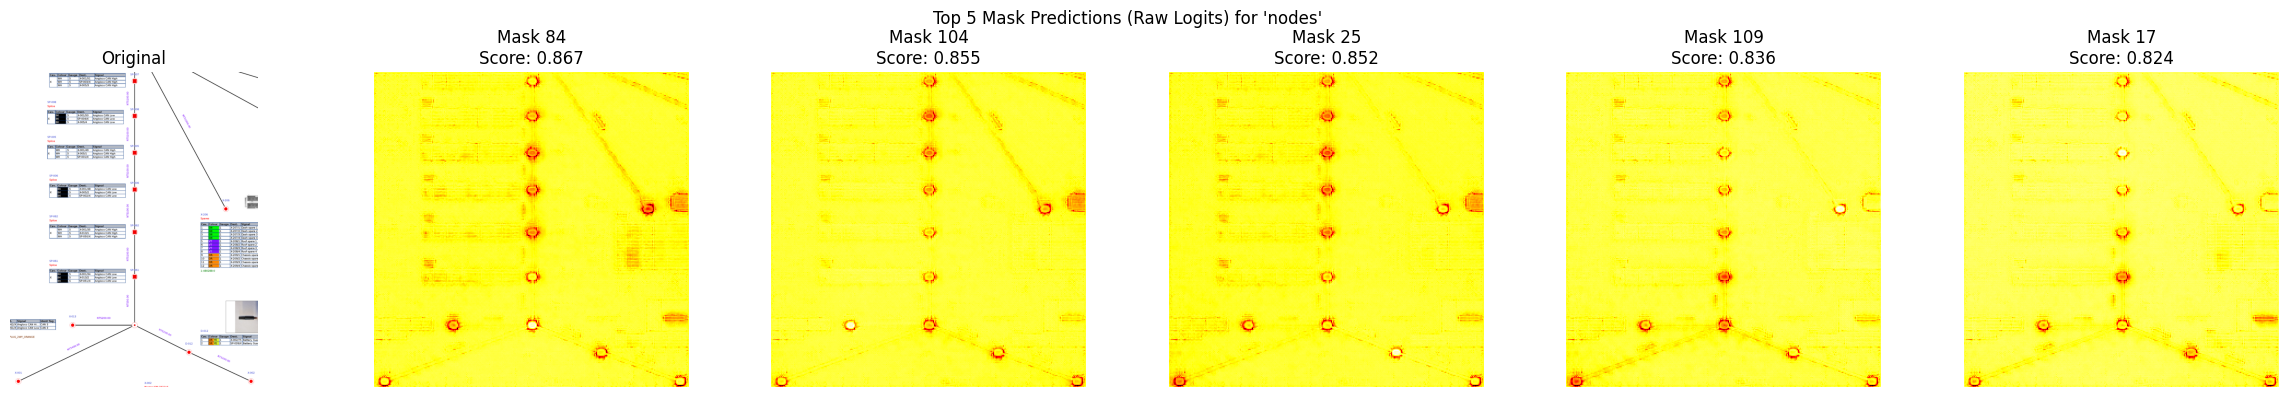

In [4]:
# Cell 4: Visualize Mask Logits (before thresholding)

# pred_masks are the raw logits before sigmoid
mask_logits = outputs.pred_masks  # Shape: [batch, num_queries, H, W]
print(f"Mask logits shape: {mask_logits.shape}")

# Get the confidence scores to find top predictions
logits = outputs.pred_logits.sigmoid()  # [batch, num_queries, 1]
scores = logits.squeeze(-1)[0]  # [num_queries]

# Get top 5 scoring masks
top_k = min(5, len(scores))
top_indices = scores.argsort(descending=True)[:top_k]

fig, axes = plt.subplots(1, top_k + 1, figsize=(4 * (top_k + 1), 4))

# Original image
axes[0].imshow(image)
axes[0].set_title("Original")
axes[0].axis('off')

# Top masks (as heatmaps showing confidence)
for i, idx in enumerate(top_indices):
    mask = mask_logits[0, idx].float().cpu().numpy()
    score = scores[idx].item()
    axes[i + 1].imshow(mask, cmap='hot')
    axes[i + 1].set_title(f"Mask {idx.item()}\nScore: {score:.3f}")
    axes[i + 1].axis('off')

plt.suptitle(f"Top {top_k} Mask Predictions (Raw Logits) for '{TEXT_PROMPT}'")
plt.tight_layout()
plt.show()

In [5]:
# Cell 5: Explore Vision Encoder Hidden States (Patch Embeddings)

if hasattr(outputs, 'vision_hidden_states') and outputs.vision_hidden_states is not None:
    hidden_states = outputs.vision_hidden_states
    print(f"Number of hidden state layers: {len(hidden_states)}")
    for i, hs in enumerate(hidden_states):
        print(f"  Layer {i}: {hs.shape}")
else:
    print("Vision hidden states not available in output.")
    print("\nLet's manually extract from vision encoder...")
    
    # Get just the pixel values
    pixel_values = inputs['pixel_values']
    print(f"Input pixel_values shape: {pixel_values.shape}")
    
    # Run vision encoder separately
    with torch.no_grad():
        vision_outputs = model.vision_encoder(
            pixel_values, 
            output_hidden_states=True
        )
    
    print(f"\nVision encoder output keys: {vision_outputs.keys() if hasattr(vision_outputs, 'keys') else dir(vision_outputs)}")

Number of hidden state layers: 33
  Layer 0: torch.Size([1, 72, 72, 1024])
  Layer 1: torch.Size([1, 72, 72, 1024])
  Layer 2: torch.Size([1, 72, 72, 1024])
  Layer 3: torch.Size([1, 72, 72, 1024])
  Layer 4: torch.Size([1, 72, 72, 1024])
  Layer 5: torch.Size([1, 72, 72, 1024])
  Layer 6: torch.Size([1, 72, 72, 1024])
  Layer 7: torch.Size([1, 72, 72, 1024])
  Layer 8: torch.Size([1, 72, 72, 1024])
  Layer 9: torch.Size([1, 72, 72, 1024])
  Layer 10: torch.Size([1, 72, 72, 1024])
  Layer 11: torch.Size([1, 72, 72, 1024])
  Layer 12: torch.Size([1, 72, 72, 1024])
  Layer 13: torch.Size([1, 72, 72, 1024])
  Layer 14: torch.Size([1, 72, 72, 1024])
  Layer 15: torch.Size([1, 72, 72, 1024])
  Layer 16: torch.Size([1, 72, 72, 1024])
  Layer 17: torch.Size([1, 72, 72, 1024])
  Layer 18: torch.Size([1, 72, 72, 1024])
  Layer 19: torch.Size([1, 72, 72, 1024])
  Layer 20: torch.Size([1, 72, 72, 1024])
  Layer 21: torch.Size([1, 72, 72, 1024])
  Layer 22: torch.Size([1, 72, 72, 1024])
  Layer 23

In [6]:
# Cell 6: Understand the Patch Size and Feature Maps

# SAM3 uses ViT with patch_size typically 14 or 16
# For 1008x1008 input with patch_size=14:
# Number of patches = (1008/14) x (1008/14) = 72 x 72 = 5184 patches

input_size = 1008
patch_size = 14  # typical for SAM models

num_patches_per_side = input_size // patch_size
total_patches = num_patches_per_side ** 2

print(f"Input size: {input_size}x{input_size}")
print(f"Patch size: {patch_size}x{patch_size}")
print(f"Patches per side: {num_patches_per_side}")
print(f"Total patches: {total_patches}")
print(f"\nEach patch embedding represents a {patch_size}x{patch_size} pixel region")
print(f"\nBut the mask decoder upsamples back to {input_size}x{input_size} (or original size)")

Input size: 1008x1008
Patch size: 14x14
Patches per side: 72
Total patches: 5184

Each patch embedding represents a 14x14 pixel region

But the mask decoder upsamples back to 1008x1008 (or original size)


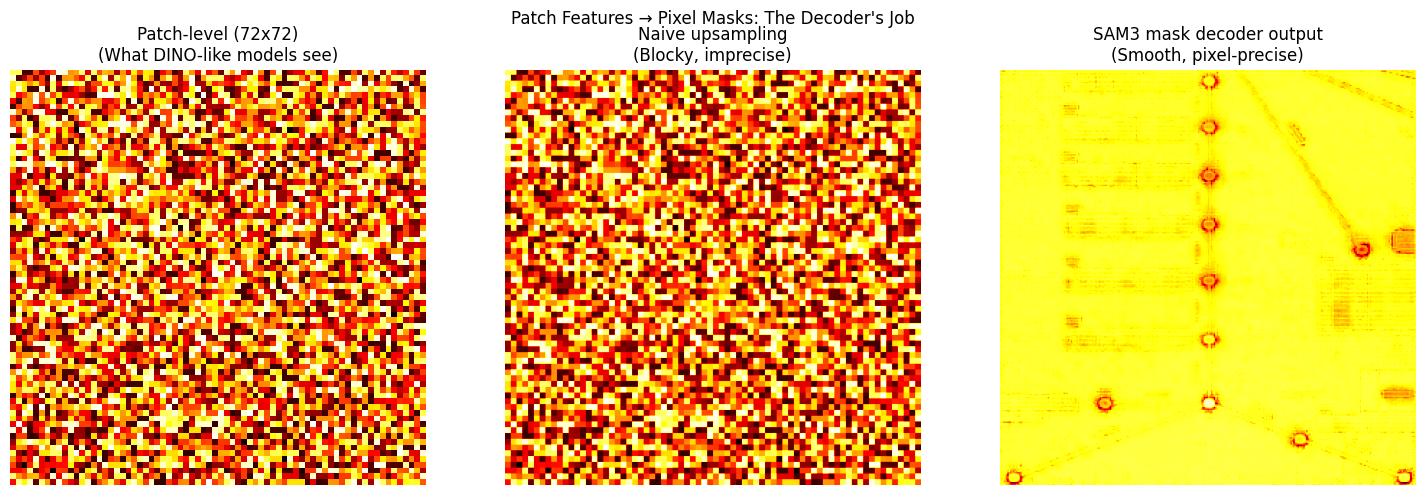

In [7]:
# Cell 7: Compare Patch-level vs Pixel-level

# This shows how coarse patch features become fine pixel masks

# Get one of the top masks
top_idx = top_indices[0]
mask_logit = mask_logits[0, top_idx].float().cpu().numpy()

# Simulate what patch-level would look like (downsampled)
from PIL import Image as PILImage
mask_pil = PILImage.fromarray((mask_logit * 255).astype(np.uint8))

# Downsample to patch resolution
patch_res = mask_pil.resize((num_patches_per_side, num_patches_per_side), PILImage.NEAREST)
# Upsample back with nearest neighbor (blocky)
blocky = patch_res.resize(mask_pil.size, PILImage.NEAREST)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(np.array(patch_res), cmap='hot')
axes[0].set_title(f"Patch-level ({num_patches_per_side}x{num_patches_per_side})\n(What DINO-like models see)")
axes[0].axis('off')

axes[1].imshow(np.array(blocky), cmap='hot')
axes[1].set_title("Naive upsampling\n(Blocky, imprecise)")
axes[1].axis('off')

axes[2].imshow(mask_logit, cmap='hot')
axes[2].set_title(f"SAM3 mask decoder output\n(Smooth, pixel-precise)")
axes[2].axis('off')

plt.suptitle("Patch Features → Pixel Masks: The Decoder's Job")
plt.tight_layout()
plt.show()

## Summary: How SAM3 Gets Pixel-Level Precision

1. **Vision Encoder (ViT)**: Creates patch embeddings (72x72 for 1008 input)
2. **Feature Pyramid Network (FPN)**: Creates multi-scale features (different resolutions)
3. **Text Encoder**: Encodes the text prompt into embeddings
4. **Cross-Attention**: Text features attend to visual features (finds relevant patches)
5. **Mask Decoder**: Upsamples from patch-level to pixel-level using:
   - Learned transposed convolutions
   - Skip connections from FPN
   - Bilinear interpolation
6. **Final mask**: Pixel-level, precise boundaries

The "magic" is in the **trained decoder** that learns to reconstruct precise boundaries from coarse features.